In [8]:
# import sys
# ! {sys.executable} -m pip install keras tensorflow

In [17]:
! {sys.executable} --version

Python 3.6.5 :: Anaconda, Inc.


In [18]:
import os
import numpy as np

from keras.models import load_model

from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.image import ContainerImage
from azureml.core.webservice import Webservice
from azureml.core.webservice import AciWebservice

ModuleNotFoundError: No module named 'azureml.core'

In [16]:
import sys
! python -m pip install --upgrade azureml-sdk[notebooks,automl]

  Using cached https://files.pythonhosted.org/packages/04/9d/092f71894e11ce40bac33d72fee342284f754fa07c4e3a33a230b69445fb/azureml_sdk-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/6c/d1a7dcc76d07ab5aec38966a9d3dfb420331e1689e0571aacb2dba83e10b/azureml_core-1.0.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/37/a7/2a7539e33df3eb84f061cf43a3b306a0c57f0f965f5bb5d22f22f762e383/azureml_pipeline-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b3/ae/c6f4a086f2bd7c0fdbbda9c3b21b08bf1ed516dd01400d5d08dbc2b6508d/azureml_train-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/00/a9/df3b74592d5ca47cd61754518248ef2f76401a70bac35c041889bb4b78d0/azureml_train_automl-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8c/36/055f787b606b23840542fef324cb79f57d6fc48368eb7c4e695b0220f664/azureml_widgets-1.0.8-py3-none-any.whl
  Using cached https://files.pyth

azure-cli-core 2.0.55 has requirement azure-mgmt-resource==2.0.0, but you'll have azure-mgmt-resource 2.1.0 which is incompatible.


In [2]:
# sub_key = os.getenv("AZURE_SUBSCRIPTION")
model_name = "keras-gear-cnn-0.8418.h5"

ws = Workspace.from_config()
(ws.name, ws.resource_group)

Found the config file in: C:\Users\jaearle\Documents\Code\PortlandOpenHackChallenges\aml_config\config.json


('keras-gear-ws', 'PortlandOpenHack')

In [3]:
os.path.isfile("score.py")

True

In [4]:
os.path.isfile("myenv.yml")

True

In [5]:
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "Image for Keras CNN gear classification",
                                                  tags = {"data": "gear", "type": "classification"})

In [6]:
aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {"data": "gear", "type": "classification"},
                                               description = 'Gear classification')

In [7]:
service_name = 'keras-gear-svc'
service = Webservice.deploy(deployment_config = aci_config,
                                image_config = image_config,
                                model_paths = [model_name],
                                name = service_name,
                                workspace = ws)

service.wait_for_deployment(show_output = True)
print(service.state)

Registering model keras-gear-cnn-0.8418.h5
Creating image
Image creation operation finished for image keras-gear-svc:2, operation "Succeeded"
Creating service
Running......................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


In [8]:
# service_name = 'keras-gear-svc'
# service = Webservice(ws, service_name)

In [8]:
service.scoring_uri

'http://40.117.229.60:80/score'

In [36]:
import random
import score
import json
import matplotlib.pyplot as plt
x = np.load("X_test.npy")
img = random.choice(x)

# img.reshape((1, 128, 128, 3))
# img.shape
input_json = json.dumps({ "data": np.asarray(img).tolist() })
input_bytes = bytes(input_json, encoding="utf8")

score.init()
res1 = json.loads(score.run(input_bytes))
res2 = json.loads(service.run(input_bytes))
print(res1, res2)

[[0.00012202731886645779, 0.0003532914270181209, 0.0002908363821916282, 0.010527593083679676, 0.9854631423950195, 1.435597027921176e-06, 0.00028719677357003093, 0.0005264599458314478, 6.522625335492194e-05, 0.0012048122007399797, 0.0011358917690813541, 2.2195947167347185e-05]] [[0.00012202730431454256, 0.00035329139791429043, 0.00029083635308779776, 0.010527591221034527, 0.98546302318573, 1.4355968005475006e-06, 0.00028719674446620047, 0.0005264598876237869, 6.522624607896432e-05, 0.001204812084324658, 0.0011358916526660323, 2.2195943529368378e-05]]


In [37]:
classes = {
    0: "axes",
    1: "boots",
    2: "carabiners",
    3: "crampons",
    4: "gloves",
    5: "hardshell_jackets",
    6: "harnesses",
    7: "helmets",
    8: "insulated_jackets",
    9: "pulleys",
    10: "rope",
    11: "tents"
}


for i, v in enumerate(res2[0]):
    print(classes[i], v*100)

print("Top prediction: {}".format(classes[np.argmax(res2[0])]))

axes 0.012202730431454256
boots 0.03532913979142904
carabiners 0.029083635308779776
crampons 1.0527591221034527
gloves 98.546302318573
hardshell_jackets 0.00014355968005475006
harnesses 0.028719674446620047
helmets 0.05264598876237869
insulated_jackets 0.006522624607896432
pulleys 0.12048120843246579
rope 0.11358916526660323
tents 0.002219594352936838
Top prediction: gloves


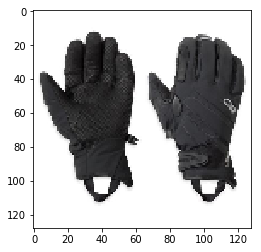

In [38]:
import matplotlib.pyplot as plt
plt.imshow(img)